This notebook is based on Aurelien Geron's Chapter 2 of Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow book (2nd edition)

Book link: https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/

Geron's git hub link for this chapter 2: https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb




# Intro

Our task is to predict median house values in Californian districts, given a number of features from these districts.

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

In [2]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

##  Basic stats

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

C:\Users\Riyan Aditya\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Riyan Aditya\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Riyan Aditya\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Riyan Aditya\Anaconda3\lib\site-pac

Saving figure attribute_histogram_plots


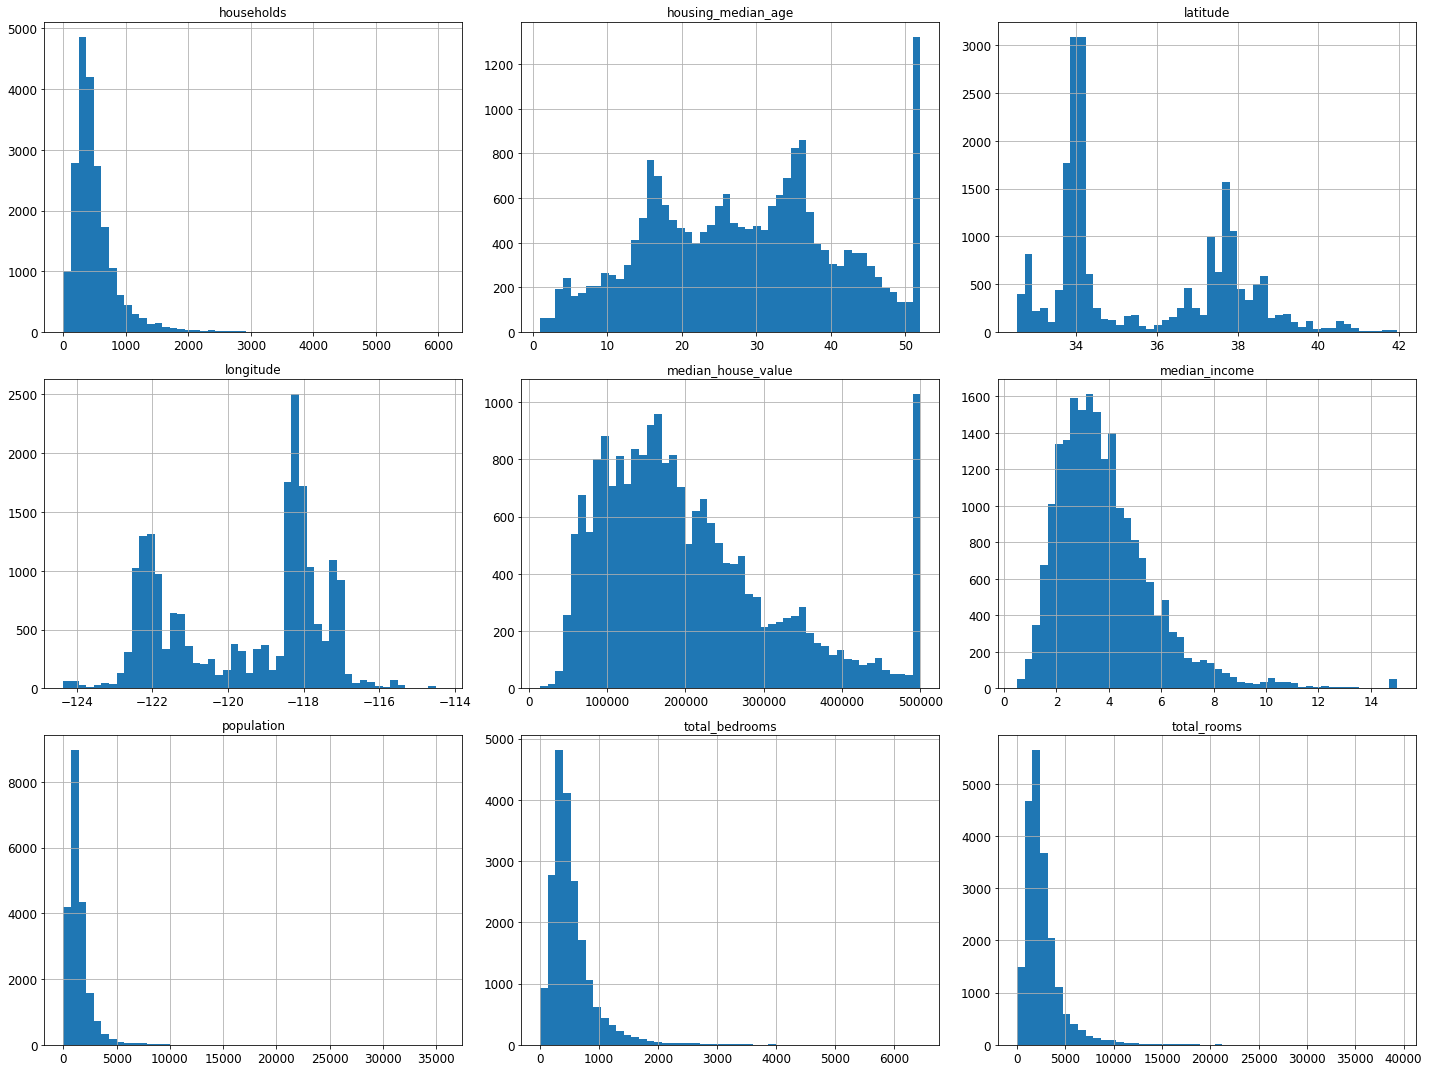

In [9]:
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

Note: ocean proximity is not plot since it is categorical data

We can notice several things from the histogram here:
* The median income looks small. The book tells us that it is in 10,000 USD unit
* The median income has been capped (max at 15)
* The median age and house value have also been capped. 
* Many of the histograms are tail heavy

## Train test split

In [10]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [11]:
# split to train & test set
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [12]:
test_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
20046    -119.01     36.06                25.0       1505.0             NaN   
3024     -119.46     35.14                30.0       2943.0             NaN   
15663    -122.44     37.80                52.0       3830.0             NaN   
20484    -118.72     34.28                17.0       3051.0             NaN   
9814     -121.93     36.62                34.0       2351.0             NaN   

       population  households  median_income  median_house_value  \
20046      1392.0       359.0         1.6812             47700.0   
3024       1565.0       584.0         2.5313             45800.0   
15663      1310.0       963.0         3.4801            500001.0   
20484      1705.0       495.0         5.7376            218600.0   
9814       1063.0       428.0         3.7250            278000.0   

      ocean_proximity  
20046          INLAND  
3024           INLAND  
15663        NEAR BAY  
20484       <1H OCEAN  
9814       NEAR OCEAN

## Importance of sampling

The method in 3.2 is good. But we need to make sure that population sampling is representative. For example. The housing median income below has a long tail / skewed. 

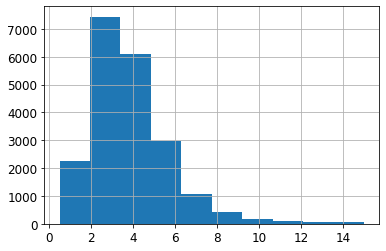

In [13]:
housing['median_income'].hist()

What we can do is to redistribute the data so we have less bins. One method is as the following: 
category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on:

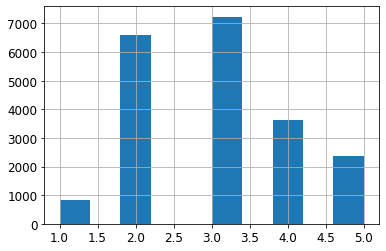

In [14]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist()

Now we can use scikitlearn's StratifiedShuffleSplit

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [16]:
# income category proportion in the test set
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [17]:
# income category proportion in the full data set
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

As you can see above, the test set has a similar income distribution than the full dataset

In [18]:
# remove the "income_cat" attribute so data is back to its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Visualise data to gain insight

Only play with the training set data

In [19]:
housing = strat_train_set.copy()

Saving figure bad_visualization_plot


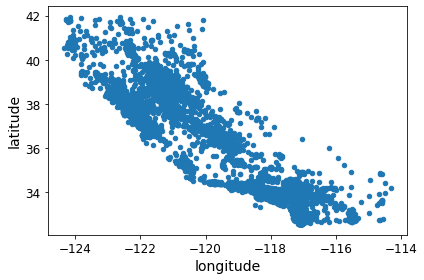

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


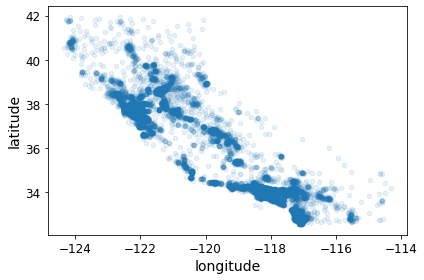

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

Now, what if we plot based on other metrics
The size represents the population
The color represents the housing value

C:\Users\Riyan Aditya\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Riyan Aditya\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Riyan Aditya\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Riyan Aditya\Anaconda3\lib\site-pac

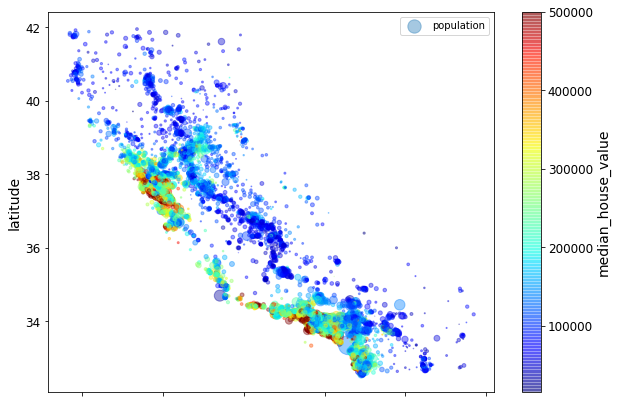

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

## A better map with geographical layer

In [23]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x205843002c8>)

Saving figure california_housing_prices_plot


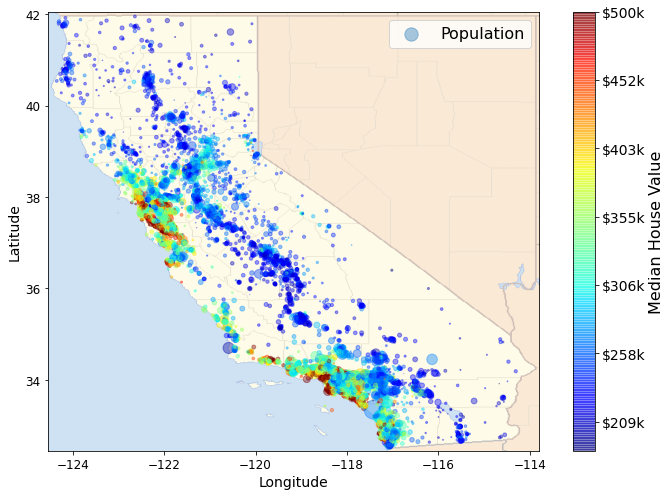

In [24]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

The house prices seem to correlate with location (close to ocean more expensive) and to opupation dnesity

## Looking for correlation

In [25]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


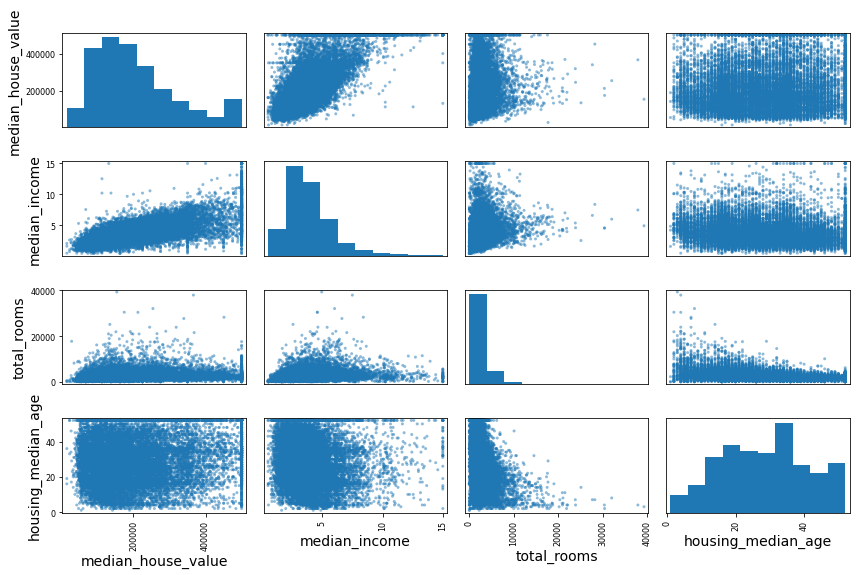

In [26]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

most promising seems to be median_house_value to median_income, so let's zoom in

Saving figure income_vs_house_value_scatterplot


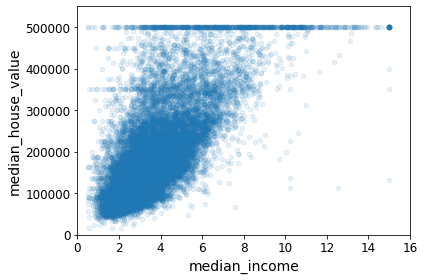

In [27]:
housing.plot(kind='scatter',x='median_income', y='median_house_value', alpha = 0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

## experimenting with attribute combination

This is called feature engineering
For example. Total number of rooms in a district does not make sense if you do not know how many households there are => hence a metric such as rooms per household makes more sense

So, feature engineer some other metric

In [28]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

lets look at the correlation matrix again

In [29]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Prepare the data for ML algorithm

lets start again with a clean data (without the feature engineering that we just explored)

Also, drop median house values label

In [30]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [31]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

## Dealing with missing data

In [32]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


We can see that total_bedrooms have some missing value (approx 160 rows)

In [33]:
# How to see the incomplete rows
sample_incomplete_rows = housing[housing.isnull().any(axis=1)]
sample_incomplete_rows.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0             NaN   
6068     -117.86     34.01                16.0       4632.0             NaN   
17923    -121.97     37.35                30.0       1955.0             NaN   
13656    -117.30     34.05                 6.0       2155.0             NaN   
19252    -122.79     38.48                 7.0       6837.0             NaN   

       population  households  median_income ocean_proximity  
4629       3296.0      1462.0         2.2708       <1H OCEAN  
6068       3038.0       727.0         5.1762       <1H OCEAN  
17923       999.0       386.0         4.6328       <1H OCEAN  
13656      1039.0       391.0         1.6675          INLAND  
19252      3468.0      1405.0         3.1662       <1H OCEAN

We have 3 options:
* Option 1: get rid of the corresponding districts (delete the 160 rows)
* Option 2: get rid the whole column
* Option 3: set the values to some value (eg: zero, mean, median etc). In the example below, we will use median

In [34]:
# option 1
#housing.dropna(subset=["total_bedrooms"])    

# option 2
#housing.drop("total_bedrooms", axis=1)       

# option 3
#median = housing["total_bedrooms"].median()  
#housing["total_bedrooms"].fillna(median, inplace=True)

Alternatively, scikit learn provides SimpelImputer. In this case, lets replace the missing value with the median (similar to Option 3 described above)

In [35]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# Note that median can only be computed in numerical data. So we need to drop the ocean proximity column
housing_num = housing.drop("ocean_proximity", axis=1)

#Call the imputer to the training data
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [36]:
# we can view the results using its statistics instance variable
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [37]:
# Use the training imputer to transform the training set by replacing all missing values with the learned medians
X = imputer.transform(housing_num)

# but the above is in array. lets put it back to DF
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [38]:
#check that housing_tr really filled in the missing values
# As you can see here, the total bedrooms have been filled in
housing_tr.loc[sample_incomplete_rows.index.values]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0           433.0   
6068     -117.86     34.01                16.0       4632.0           433.0   
17923    -121.97     37.35                30.0       1955.0           433.0   
13656    -117.30     34.05                 6.0       2155.0           433.0   
19252    -122.79     38.48                 7.0       6837.0           433.0   
...          ...       ...                 ...          ...             ...   
3376     -118.28     34.25                29.0       2559.0           433.0   
4691     -118.37     34.07                50.0       2519.0           433.0   
6052     -117.76     34.04                34.0       1914.0           433.0   
17198    -119.75     34.45                 6.0       2864.0           433.0   
4738     -118.38     34.05                49.0        702.0           433.0   

       population  households  median_income  
4629       3296.0      1462.0         2.2708  
6068       3038.0       727.0         5.1762  
17923       999.0       386.0         4.6328  
13656      1039.0       391.0         1.6675  
19252      3468.0      1405.0         3.1662  
...           ...         ...            ...  
3376       1886.0       769.0         2.6036  
4691       1117.0       516.0         4.3667  
6052       1564.0       328.0         2.8347  
17198      1404.0       603.0         5.5073  
4738        458.0       187.0         4.8958  

[158 rows x 8 columns]

## Dealing with text and categorical attributes

We knew that we have one categorical value: ocean_proximity

Most ML algorithm prefer to work with number. so we need to translate them

In [39]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN
19480          INLAND
8879        <1H OCEAN
13685          INLAND
4937        <1H OCEAN
4861        <1H OCEAN

### OrdinalEncoder

One method is using Scikitlearn's OrdinalEncoder class

In [40]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [41]:
# In this case, each categories are mapped to a value (eg: 0 is <1H ocean)
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Note that this method may create a problem. Category 0 (<1H ocean) is more similar to category 4 (near ocean).
The above method is better for an ordered cateogory

### OneHotEncoding

Another method is using OneHotEncoding

In this case, only one state is hot (1), while the other is not (0)

In [42]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [43]:
# As you can see here, for each row, only one state that is hot as "1"
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [44]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Note: if the categorical attribute is large, OneHotEncoding will result in a large nunber of input features. This may slow down training and degrade performance. 

A better way maybe to replace ocean_proximity with the actual distance to the ocean (ie: a more useful numerical features related to the categories)
But in this example, it does not matter since we only have 5 categories

It might matter in caategories such as "country code" for a worldwide data. This country code may be replaced by something like the country's population instead. 

Another alternative is to use a learnable, low dimensional vector called "embedding"

## Custom transformers

To combine specific attributes (such as the number of rooms per household we discussed earlier), we need to do our own transformers

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In the above code, we added one hyperparameter (add_bedrooms per room). Set for True as default. This will allow us to find out whether it will be helpful to add this parameter or not. 
This will help us to check later whether adding this will be usefull or not

Note that the above code for now, setting bedrooms per room as FALSE

In [46]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

longitude latitude housing_median_age total_rooms total_bedrooms  \
17606   -121.89    37.29                 38        1568            351   
18632   -121.93    37.05                 14         679            108   
14650    -117.2    32.77                 31        1952            471   
3230    -119.61    36.31                 25        1847            371   
3555    -118.59    34.23                 17        6592           1525   

      population households median_income ocean_proximity rooms_per_household  \
17606        710        339        2.7042       <1H OCEAN             4.62537   
18632        306        113        6.4214       <1H OCEAN             6.00885   
14650        936        462        2.8621      NEAR OCEAN             4.22511   
3230        1460        353        1.8839          INLAND             5.23229   
3555        4459       1463        3.0347       <1H OCEAN             4.50581   

      population_per_household  
17606                   2.0944  
18632                  2.70796  
14650                  2.02597  
3230                   4.13598  
3555                   3.04785

## Feature scaling

In our data, number of rooms ranges from 6 to 39320
While median income only from 0 to 15

2 method:
* min max scaling / normalisation => shifted and rescaled so they are between 0 and 1. Use MinMaxScaler
* standardisation => standardise to have a mean of 0 and some variance. Use StandardScaler

Standardisation is affected much less than outlier. 

## Transformation pipeline

Many data transformation need to be executed in the right order => use pipeline

In [47]:
# to process only the numerical attributes

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), #simple imputer with median (to deal with missing data)
        ('attribs_adder', CombinedAttributesAdder()),  #create custom transformer (using the class we created before)
        ('std_scaler', StandardScaler()),              #Feature scaling with standardisation method
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [48]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

Alternatively, we can combine the above numerical transformer with the categorical transformer (one hot encoding) that we have chosen for the ocean_proximity column

In [49]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),     #using the num_pipeline we have defined above
        ("cat", OneHotEncoder(), cat_attribs),  #using OneHotEncoder
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [50]:
housing_prepared.shape

(16512, 16)

In [51]:
housing_labels.shape

(16512,)

# Select and train model

## Linear regression

In [55]:
#why does the following line need to be run twice? first time run it always throw an error

In [56]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [57]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [58]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [59]:
# USe RMSE to measure error for the whole training data (housing_prepared)

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

Most housing value are between 120k and 265k. So an error of 68k isnt good => example of model underfitting the training data

In [60]:
# alternatively, error measurement via MAE
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.895990018966

## Try using decision tree

lets try using decision tree model

In [61]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [62]:
# make prediction
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

error of 0 ??? Most likely the model has overfit the data. 

We actually need to validate and adjust the model before testing with test set

# Fine tune your model

One way to evaluate decision tree is by using train test split.

Alternatively, use scikit learn K-fold cross-validation. 
This split training set into 10 distinct set called folds.
Then it trains and evalutes the decision tree model 10x. Every time picking a different fold for evaluation while training on the other 9 folds.
The result is an array containing the 10 evaluation scores

## Cross validation for the decision tree

In [63]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [64]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


Now we can observe that the decision tree actually perform worse than the linear regression model

## Cross validation for the linear model

In [65]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983425


## Try new model => Random Forest

In [66]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [67]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

In [68]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


Much better score. Random forest seems promising

However note that if we train everything (using housing_prepared), we have RMSE of 18600. If we use cross validation, we have RMSE of 50182. This means the model still overfit

## Lets try Support Vector Regression (SVR)

In [69]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

# Fine tune model 2

## Grid search

One optione to finetune is change hyperparameter manually yourself

Scikitlearn GridSearchCV search for you. Only need to tell which parameters you want to experimetn and want values to find out. It iwll use cross validation to evaluate all possible combinations of hyperparameter values

### GridSearch the RandomForest

In [70]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],
  

The best hyper parameter combination found:

In [71]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [72]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [86]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [87]:
# To view the cross validation score
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.05791727153 {'max_features': 2, 'n_estimators': 3}
55627.16171305252 {'max_features': 2, 'n_estimators': 10}
53384.57867637289 {'max_features': 2, 'n_estimators': 30}
60965.99185930139 {'max_features': 4, 'n_estimators': 3}
52740.98248528835 {'max_features': 4, 'n_estimators': 10}
50377.344409590376 {'max_features': 4, 'n_estimators': 30}
58663.84733372485 {'max_features': 6, 'n_estimators': 3}
52006.15355973719 {'max_features': 6, 'n_estimators': 10}
50146.465964159885 {'max_features': 6, 'n_estimators': 30}
57869.25504027614 {'max_features': 8, 'n_estimators': 3}
51711.09443660957 {'max_features': 8, 'n_estimators': 10}
49682.25345942335 {'max_features': 8, 'n_estimators': 30}
62895.088889905004 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.14484390074 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.399594730654 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52725.01091081235 {'bootstrap': False, 'max_features': 3, 'n_estimators'

Best score is for max_feature 8 and n_estimators 30. The score is 49682, which is slightly better than the first RandomForest that we did (50182)

In [97]:
gs_rmse_min = (np.sqrt(-cvres["mean_test_score"])).min()
gs_rmse_min

49150.657232934034

## Randomised search

This is like grid search. BUt do random combinations by sleecting a random value for each hyperparameter at every iteration. 

In [74]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [104]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.657232934034 {'max_features': 7, 'n_estimators': 180}
51389.85295710133 {'max_features': 5, 'n_estimators': 15}
50796.12045980556 {'max_features': 3, 'n_estimators': 72}
50835.09932039744 {'max_features': 5, 'n_estimators': 21}
49280.90117886215 {'max_features': 7, 'n_estimators': 122}
50774.86679035961 {'max_features': 3, 'n_estimators': 75}
50682.75001237282 {'max_features': 3, 'n_estimators': 88}
49608.94061293652 {'max_features': 5, 'n_estimators': 100}
50473.57642831875 {'max_features': 3, 'n_estimators': 150}
64429.763804893395 {'max_features': 5, 'n_estimators': 2}


In [105]:
rs_rmse_min = (np.sqrt(-cvres["mean_test_score"])).min()
rs_rmse_min

49150.657232934034

## Ensemble method

Another way is to perform ensemble method by combining the models that perform best. THe group will often perform better than the best individual model

## Analyse the best model

In [76]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [77]:
# Display the important scores next to the attribute name
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs # numerical attributes + 3 of the new ones we created + the 4 from OHEncoding
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

Looking at this, ocean_proximity seems useless exceot "<1H ocean", maybe wanna try to drop the others

# Evaluate against test set

Now we want to: 
* get the predictors and labels from the test set
* run the full_pipeline using transform() ==> not the fit_transform() as you do not want to fit the test set
* Evaluate the final model score

In [78]:
# decided that final model is the one we found after we hyperparameter the grid search
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [79]:
final_rmse

47730.22690385927

Sometimes knowing just the final RMSE isnt enough. How do we know if this is better than what currently already launched. May want to know 95% CI

In [109]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
final_ci_ttest = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))
final_ci_ttest

array([45685.10470776, 49691.25001878])

Or use z-score

In [81]:
m = len(squared_errors)
mean = squared_errors.mean()
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136455, 49690.68623889413)

# Summary

In [82]:
lin_rmse, tree_rmse, forest_rmse

(68628.19819848923, 0.0)

In [84]:
lin_rmse_scores.mean(), tree_rmse_scores.mean(), forest_rmse_scores.mean()

(69052.46136345083, 71407.68766037929, 50182.303100336096)

In [102]:
gs_rmse_min

49150.657232934034

In [106]:
rs_rmse_min

49150.657232934034

In [107]:
final_rmse

47730.22690385927

In [110]:
final_ci_ttest

array([45685.10470776, 49691.25001878])

In [130]:
# plot table
import plotly
plotly.offline.init_notebook_mode()
import plotly.figure_factory as ff

data_matrix = [['Model','RMSE','RMSE cross validation'],
               ['Training data:','',''],
               ['Linear',lin_rmse.round(0),lin_rmse_scores.mean().round(0)],
               ['Decision tree',tree_rmse.round(0),tree_rmse_scores.mean().round(0)],
               ['Random forest','-', forest_rmse_scores.mean().round(0)],
               ['Random forest with GridSearch','-', gs_rmse_min.round(0)],
               ['Support Vector Regression',svm_rmse.round(0),'-'],
               [''],
               ['Test data:','',''],
               ['Final RMSE',final_rmse.round(0),''],
               ['Final confidence interval',final_ci_ttest.round(0),''],

              ]

table = ff.create_table(data_matrix)
plotly.offline.iplot(table, filename='simple_table')